# Inżynieria cech

<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>Feature Engineering</b> polega na przekształcaniu surowych danych w cechy użyteczne w procesie modelowania. 
</div>

<div class="alert alert-block alert-info">
<b>Info</b> 

Tworzenie zmiennych predykcyjnych zawsze powinno opierać się przede wszystkim na zrozumieniu danych i wiedzy biznesowej związanej z danym problemem. Istnieje jednak kilka standardowych technik, które można stosować do tworzenia cech w większości problemów, można tu wyróżnić:
- przekształcanie zmiennych kategorycznych
- zmienne na podstawie cech z daty
- zmienne powstałe przez przesunięcie w czasie
- transformacje zmiennych numerycznych
- zmienne interakcji
</div>

<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
    
<b>Feature Engineering</b> stanowi jeden z ważniejszych etapów w procesie budowy uczenia maszynowego, dlatego należy mu poświęcić dużo uwagi. Często można uzyskać znacznie lepsze wyniki mając prosty model oparty na cechach predykcyjnych dobrze oddających naturę badanego zjawiska niż budując wyrafinowany model w oparciu o zbyt wąski zbiór zmiennych.
</div>

# Tworzenie przykładowych zbiorów danych

Zaprezentujemy tutaj 2 przykładowe zbiory danych o różnym charakterze oraz przykłady zmiennych predykcyjnych, które można wygenerować na ich podstawie

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def generateIceCreamSalesData(month_coef=10000, week_coef=1000, day_coef=100, random_coef =10000):
    dates = pd.date_range(start="2018-01-01", end="2020-12-31", freq ="D")
    df = pd.DataFrame(dates, columns=["SalesDate"])
    df["Month"] = df.SalesDate.dt.month
    df["Week"] = df.SalesDate.dt.isocalendar().week
    df["WeekDay"] = df.SalesDate.dt.dayofweek+1
    df["IceCreamSales"] = (-1*np.power(df.Month-6,2)+np.power(6,2))*month_coef + (-1*np.power(df.Week-27,2)+np.power(27,2))*week_coef +df.WeekDay*day_coef +random_coef * np.random.randint(low =1,high =10, size=len(df))
    return df.loc[:,["SalesDate","IceCreamSales"]]

In [11]:
IceCream_df = generateIceCreamSalesData()
IceCream_df

,SalesDate,IceCreamSales
0,2018-01-01,253100
1,2018-01-02,223200
2,2018-01-03,173300
3,2018-01-04,223400
4,2018-01-05,223500
...,...,...
1091,2020-12-27,134700
1092,2020-12-28,143100
1093,2020-12-29,93200
1094,2020-12-30,73300


In [12]:
def generate_used_cars_data(len_df =1000):
    conditions ={"very_bad":1,"bad":2,"medium":3,"good":4,"very_good":5}
    brands =["Fiat","Renault","VW", "Seat", "Skoda","Toyota", "Audi","BMW","Mercedes", "Bugatti"]
    standard_brands = ["Fiat","Renault","VW", "Seat", "Skoda","Toyota"]
    premium_brands = ["Audi","BMW","Mercedes"]
    luxury_brands = ["Bugatti"]
    dict_data ={"condition":np.random.choice(list(conditions.keys()),size=len_df, p = [0.05, 0.15, 0.3, 0.3,0.2 ]),
                "brand":np.random.choice(brands,size=len_df, p=[0.1]*10 ),
                "year_manufactured":np.random.randint(1950,2020,size =len_df)
               }
    df = pd.DataFrame(dict_data)
    df["age"] =2021- df.year_manufactured
    df["mileage"] = df.age *np.random.randint(100,10000, len_df)+np.random.randint(100,10000, len_df)
    
    df["selling_price"] = 100000*df["brand"].isin(standard_brands)+300000*df["brand"].isin(premium_brands)+600000*df["brand"].isin(luxury_brands)
    df["selling_price"] /= np.log1p(df.age)+np.log1p(df.mileage)
    df["condition_num"] = df.condition.map(lambda x:conditions[x])
    df["selling_price"] *=  np.log1p(df["condition_num"])
    df.loc[(df["brand"].isin(luxury_brands))&(df.year_manufactured<=1970)&(df["condition_num"]>3),"selling_price"] *=\
    np.log1p(df.loc[(df["brand"].isin(luxury_brands))&(df.year_manufactured<=1970)&(df["condition_num"]>3),"age"])
    df["selling_price"] = np.round(df["selling_price"])
    return df.loc[:,["selling_price","condition","mileage","brand","year_manufactured"]]

In [13]:
UsedCars_df =generate_used_cars_data()
UsedCars_df

,selling_price,condition,mileage,brand,year_manufactured
0,9847.0,good,338883,Fiat,1985
1,7899.0,medium,589817,Renault,1951
2,11231.0,good,79656,Toyota,2001
3,33941.0,good,115919,Mercedes,2009
4,38360.0,very_good,64115,Mercedes,2003
...,...,...,...,...,...
995,10204.0,medium,29430,Renault,1995
996,36737.0,very_good,119063,Audi,2003
997,8692.0,bad,14683,Seat,2001
998,16719.0,very_good,15039,Renault,2019


# Cechy tworzone na podstawie danych czasowych

Pierwszy zbiór danych nazwany tutaj IceCream_df de facto ma charakter szeregu czasowego i patrząc na poniższy wykres mógłby być z powodzeniem przewidywany dedykowanymi metodami do predykcji szeregów czasowych, jednak dla celów pokazania tworzenia zmiennych na podstawie danych o charakterze czasowym potraktujemy to zagadnienie jako problem regresyjny, w którym naszą zmienną celu będzie IceCreamSales.

<AxesSubplot:title={'center':'IceCream Sales'}, xlabel='SalesDate'>

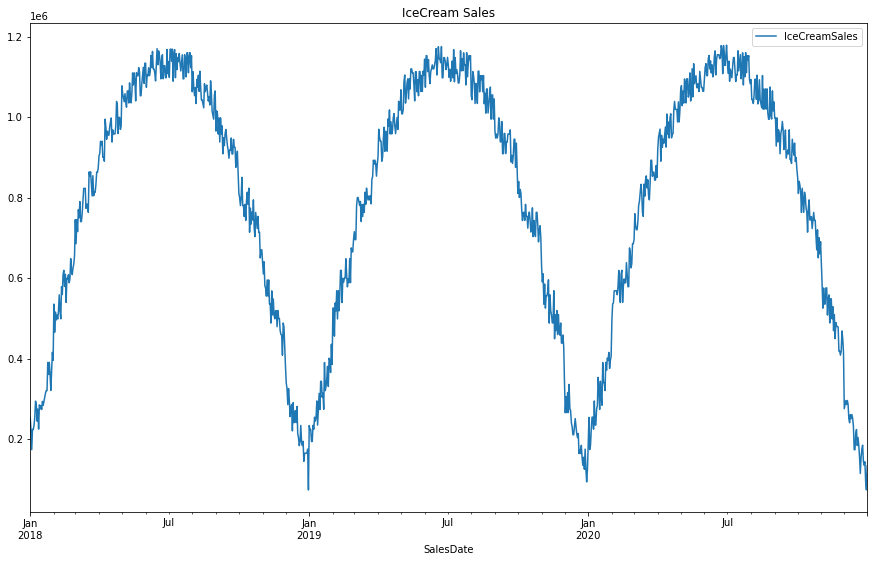

In [14]:
IceCream_df.set_index("SalesDate").plot(figsize=(15,9), title="IceCream Sales")

Wyraźnie widać tutaj, że sprzedaż lodów ma silnie sezonowy charakter, stąd cechy wyciągnięte z daty powinny znacznie ułatwić dobrą predykcję. Funkcję generującą takie cechy zaprezentowano poniżej:

In [17]:
def extract_date_features(df, date_column):
    df_temp = df.copy()
    df_temp[date_column + 'Quarter'] = df_temp[date_column].dt.quarter
    df_temp[date_column + 'Month'] = df_temp[date_column].dt.month
    df_temp[date_column + 'Week'] = df_temp[date_column].dt.isocalendar().week
    # poniżej zwracany rozkład to 0-6, dodajemy 1 aby przejsc na bardziej intuicyjne wrtości 1-7
    df_temp[date_column + 'WeekDay'] = df_temp[date_column].dt.dayofweek + 1 
    df_temp[date_column + 'YearDay'] = df_temp[date_column].dt.dayofyear
    df_temp[date_column + 'isWeekend'] = np.where(df_temp[date_column + 'WeekDay']>5,1,0)
    return df_temp

In [18]:
IceCream_df_extended = extract_date_features(IceCream_df,"SalesDate")
IceCream_df_extended

,SalesDate,IceCreamSales,SalesDateQuarter,SalesDateMonth,SalesDateWeek,SalesDateWeekDay,SalesDateYearDay,SalesDateisWeekend
0,2018-01-01,253100,1,1,1,1,1,0
1,2018-01-02,223200,1,1,1,2,2,0
2,2018-01-03,173300,1,1,1,3,3,0
3,2018-01-04,223400,1,1,1,4,4,0
4,2018-01-05,223500,1,1,1,5,5,0
...,...,...,...,...,...,...,...,...
1091,2020-12-27,134700,4,12,52,7,362,1
1092,2020-12-28,143100,4,12,53,1,363,0
1093,2020-12-29,93200,4,12,53,2,364,0
1094,2020-12-30,73300,4,12,53,3,365,0


# Cechy powstałe przez przesunięcie w czasie

Analizując wykres można zaobserwować, że sprzedaż lodów nie jest liniowo zależna od zmiennych takich jak numer kwartału, numer miesiąca czy numer tygodnia, aby uzyskać lepsze wyniki warto zbudować cechy w oparciu o przesunięte w czasie wartości zmiennej celu.

<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
    
Przy korzystaniu ze zmiennych przesuniętych w czasie, w szczególności opartych o wcześniejsze wartości zmiennej celu nalezy zawsze wziąc pod uwagę jakie dane będziemy mieli dostępne na moment predykcji, inaczej możemy popełnić jeden z najczęstszych błędów czyli <b>data leakage</b>. 
Przy założeniu, że mamy przewidywać sprzedaż lodów np na rok do przodu wykorzystanie sprzedaży lodów z dnia poprzedniego stanowi data leakage, ponieważ ta informacja nie będzie dostępna na moment predykcji w tej samej formie. Moglibyśmy natomiast uwzględnić sprzedaż lodów sprzed roku, jako, że ta informacja będzie dostępna w tej samej formie.
</div>

Tutaj dla uproszczenia zakładamy chwilowo, że horyzont predykcji to tylko 1 dzień do przodu, co pozwoli zaprezentować większy zakres zmiennych przesuniętych w czasie.

In [ ]:
def get_shifted_target_values(df, lag_values, date_column, target_column):
    df_temp = df.copy()
    df_temp =df_temp.sort_values(by=date_column)
    for lag in lag_values:
        df_temp[target_column +"_lagged_" + str(lag)] = df_temp[target_column].shift(lag)
    return df_temp

Uwzględniając, że przewidujemy z horyzontem czasowym tylko na dzień w przód, pierwszym kandydatem na wartość przesunięcia jest 1 dzień, jako, że w danych o charakterze szeregu czasowego podobieństwo kolejnych obserwacji będzie siłą rzeczy relatywnie wysokie. Z analizy wykresu można łatwo wywnioskować, że wartośc przesunięcia 365 dni również będzie miała dużą siłę predykcyjną. Ponadto można tutaj wypróbować 7 dni co powinno być przydatne w przypadku tygodniowej sezonowości danych

In [ ]:
IceCream_df_extended = get_shifted_target_values(IceCream_df_extended, [1,7,365], "SalesDate","IceCreamSales")
IceCream_df_extended

,SalesDate,IceCreamSales,SalesDateQuarter,SalesDateMonth,SalesDateWeek,SalesDateWeekDay,SalesDateYearDay,SalesDateisWeekend,IceCreamSales_lagged_1,IceCreamSales_lagged_7,IceCreamSales_lagged_365
0,2018-01-01,253100,1,1,1,1,1,0,<NA>,<NA>,<NA>
1,2018-01-02,213200,1,1,1,2,2,0,253100,<NA>,<NA>
2,2018-01-03,193300,1,1,1,3,3,0,213200,<NA>,<NA>
3,2018-01-04,253400,1,1,1,4,4,0,193300,<NA>,<NA>
4,2018-01-05,213500,1,1,1,5,5,0,253400,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-12-27,154700,4,12,52,7,362,1,144600,233700,114600
1092,2020-12-28,73100,4,12,53,1,363,0,154700,194100,124700
1093,2020-12-29,63200,4,12,53,2,364,0,73100,154200,83100
1094,2020-12-30,143300,4,12,53,3,365,0,63200,164300,143200


Widzimy, że początek zbioru danych zawiera teraz wartości puste, ze względu na fakt, że dla wartości z roku 2018 nie istniały obserwacje cofnięte o rok. Do pokazywania liczby niepustych wartości w ramce danych przydatna jest funkcja info z biblioteki pandas

In [ ]:
IceCream_df_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 0 to 1095
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesDate                 1096 non-null   datetime64[ns]
 1   IceCreamSales             1096 non-null   Int64         
 2   SalesDateQuarter          1096 non-null   int64         
 3   SalesDateMonth            1096 non-null   int64         
 4   SalesDateWeek             1096 non-null   UInt32        
 5   SalesDateWeekDay          1096 non-null   int64         
 6   SalesDateYearDay          1096 non-null   int64         
 7   SalesDateisWeekend        1096 non-null   int32         
 8   IceCreamSales_lagged_1    1095 non-null   Int64         
 9   IceCreamSales_lagged_7    1089 non-null   Int64         
 10  IceCreamSales_lagged_365  731 non-null    Int64         
dtypes: Int64(4), UInt32(1), datetime64[ns](1), int32(1), int64(4)
memory usage: 99.5 K

oczywiście wartości puste należy potem w jakiś sposób obsłużyć, poprzez ich usunięcie lub imputację

<div class="alert alert-block alert-info">
<b>Info</b> 

Tworząc zmienne oparte o cechy przesunięte w czasie warto mieć na uwadze, że dane historyczne mogą zawierać wartości odstające. Dlatego zamiast brać wprost wartość sprzed np. 365 dni można rozważyć wygładzenie wartości stosując medianę z 5 dniowego okna, którego środek stanowi wartość sprzed 365 dni.
</div>

# Cechy kategoryczne i ich transformacje

Dla zilustrowania transformacji na zmiennych kategorycznych posłużymy się drugim z przygotowanych zbiorów danych, gdzie chcemy przewidzieć cenę sprzedaży używanego samochodu.

In [ ]:
UsedCars_df.head()

,selling_price,condition,mileage,brand,year_manufactured
0,32123.0,good,129627,Mercedes,1996
1,62394.0,medium,68446,Bugatti,2013
2,8746.0,medium,218559,Fiat,1987
3,9193.0,good,573386,Skoda,1952
4,12340.0,good,27153,Fiat,2005


jak widzimy występują tutaj 2 cechy kategoryczne condition oraz brand, na podstawie których zaprezentujemy które transformacje danych najlepiej zastosować w którym przypadku. Aby umożliwić wykorzystanie tych cech w predykcji niezbędne jest odpowiednie ich przekształcenie w wartości numeryczne

In [ ]:
UsedCars_df.condition.unique()

array(['good', 'medium', 'bad', 'very_good', 'very_bad'], dtype=object)

patrząc na atrybuty zmiennej condition widzimy, że ma ona charakter porządkowy - jesteśmy w stanie łatwo ustalić naturalną kolejność jej atrybutów. Stanowi ona zatem dobrego kandydata do zastosowania <b>kodowania porządkowego</b>

<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>kodowania porządkowe</b> (ang. *Ordinal encoding*) - reprezentacja każdego atrybutu kodowanej zmiennej jako kolejnej liczby naturalnej 
</div>

poniżej zaprezentujemy kodowanie porządkowe z użyciem transformera OrdinalEncoder, najpierw jednak podzielimy nasze dane na zbiór treningowy i testowy, aby lepiej odwzorować to, że dane treningowe są oddzielone od danych produkcyjnych, na których model będzie potem stosowany.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

tutaj dla uproszczenia stosujemy tylko prosty podział na zbiór treningowy i testowy, generalnie najlepszą praktyką jest wydzielenie osobnego zbioru testowego reprezentującego zdolność modelu do generalizacji na nowych, niewidzianych wcześniej danych i dobór najlepszego zestawu parametrów i transformacji stosując crosswalidację na zbiorze treningowym.

In [ ]:
X_train, X_test = train_test_split(UsedCars_df, test_size =0.25, random_state=42)

następnie tworzymy obiekt klasy OrdinalEncoder, określamy tutaj porządek cechy atrybutów cechy, którą chcemy przetransformować, inaczej mogą one zostać po prostu posortowane alfabetycznie co najczęściej nie będzie odpowiadało ich znaczeniu biznesowemu

In [ ]:
oe= OrdinalEncoder(categories =[['very_bad', 'bad', 'medium', 'good', 'very_good']],
                   handle_unknown ='use_encoded_value', unknown_value=np.NaN)

<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
    
Kodując atrybuty należy mieć świadomość, że na nowych danych mogą pojawić się niewidziane wcześniej wartości, które należy w jakiś sposób obsłużyć. Domyślnym zachowaniem OrdinalEncoder w takiej sytuacji jest zwrócenie wyjątku, tutaj skorzystaliśmy z przypisania mu ustalonej wartości, gdzie wybraliśmy  przypisanie wartości pustej. Następnie taką wartość można zastąpić np. dominantą ze zbioru treningowego, lub przypisać jej wartość neutralną, którą tutaj byłoby 2 odpowiadające kategorii medium.
</div>

Zdecydowanie najlepszym sposobem użycia wszystkich transformerów jest skorzystanie z <b>pipeline</b>, co zostanie zaprezentowane potem. Tutaj zaprezentujemy najprostsze wykorzystanie polegające na skorzystaniu z metod <b>fit</b> i <b>transform</b>. OrdinalEncoder stosujemy tylko do przekształcenia jednej cechy, gdyby było inaczej moglibyśmy wykonać fit na całym zbiorze treningowym a następnie przetransformować zbiory treningowy i testowy.

In [ ]:
oe.fit(X_train.condition.values.reshape(-1, 1))
X_train["condition_transformed"] = oe.transform(X_train.condition.values.reshape(-1, 1))
X_test["condition_transformed"] = oe.transform(X_test.condition.values.reshape(-1, 1))

<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
    
Jeśli nie korzystamy z pipeline należy zwrócić szczególną uwagę żeby metody fit używać tylko na zbiorze treningowym a następnie mając już "nauczony" transformer stosować metodę transform na pozostałych zbiorach. Inaczej może dojść do przecieku informacji ze zbioru testowego.
</div>

możemy jeszcze sprawdzić czy przypisanie atrybutów na zbiorach treningowym i testowym jest prawidłowe, a następnie pozbyć się pierwotnej kolumny, wartości pierwotne mogą być łatwo odzyskane z przetransformowanych danych stosując metodę <b>inverse_transform</b>

In [ ]:
X_train[["condition","condition_transformed"]].drop_duplicates().sort_values(by="condition_transformed")

,condition,condition_transformed
323,very_bad,0.0
894,bad,1.0
82,medium,2.0
991,good,3.0
398,very_good,4.0


In [ ]:
X_test[["condition","condition_transformed"]].drop_duplicates().sort_values(by="condition_transformed")

,condition,condition_transformed
346,very_bad,0.0
521,bad,1.0
740,medium,2.0
513,good,3.0
737,very_good,4.0


In [ ]:
X_train.drop(["condition"],axis=1, inplace=True)
X_test.drop(["condition"],axis=1, inplace=True)

In [ ]:
X_train

,selling_price,mileage,brand,year_manufactured,condition_transformed
82,7986.0,524486,VW,1956,2.0
991,10531.0,166856,Toyota,1996,3.0
789,9532.0,94191,Skoda,2000,2.0
894,7266.0,54210,VW,1954,1.0
398,11133.0,264049,Skoda,1985,4.0
...,...,...,...,...,...
106,31713.0,127914,Mercedes,1990,3.0
270,9918.0,185880,Seat,1962,3.0
860,4824.0,116011,VW,2007,0.0
435,11329.0,25782,Skoda,2014,2.0


widzimy, że do zakodowania pozostała nam jeszcze cecha - brand, w odróżnieniu od poprzednio rozważanej cechy tutaj nie ma oczywistego naturalnego porządku, dlatego należy tutaj zastosować inne podejście

<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>kodowania 1 z n</b> (ang. *One-hot encoding*) - reprezentacja każdego atrybutu kodowanej zmiennej jako osobnej zmiennej binarnej, gdzie występowanie rozważanego atrybutu dla danej obserwacji oznaczane jest jako 1 a wszystkie pozostałe atrybuty oznaczane są jako 0 
</div>

kodowanie 1 z n stanowi jeden z najczęściej używanych i najbardziej intuicyjnych sposobów kodowania, jednak jego główną wadą jest zwiększanie wymiarowości danych, co zaraz zaprezentujemy

najpierw pokażemy jak posługiwać się transformerem OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder

tworzymy obiekt klasy OneHotEncoder, podobnie jak w przypadku poprzedniego transformera, tu także domyślnym sposobem obsługi nieznanych atrybutów jest zwracanie wyjątku, my wybieramy handle_unknown="ignore" co sprawi, że nieznane atrybuty reprezentowane będą po prostu jako 0 we wszystkich zakodowanych kolumnach.

Natomiast ustawienie sparse=False sprawia, że zwracane dane będą typu np.array zamiast domyślnego sparse matrix

In [ ]:
ohe = OneHotEncoder(handle_unknown="ignore",sparse=False)

należy zwrócić uwagę, że we wszystkich transformerach z biblioteki sklearn stosowane jest to samo API, w związku z tym tutaj analogicznie jak w poprzednim przypadku możemy skorzystać z metod <b>fit</b> i <b>transform</b>

In [ ]:
ohe.fit(X_train.brand.values.reshape(-1, 1))
brand_transformed_train = ohe.transform(X_train.brand.values.reshape(-1, 1))
brand_transformed_test = ohe.transform(X_test.brand.values.reshape(-1, 1))
print(f"rozmiar zakodowanej kolumny brand na danych treningowych to: {brand_transformed_train.shape}")
print(f"rozmiar zakodowanej kolumny brand na danych testowych to: {brand_transformed_test.shape}")
print(brand_transformed_train)

rozmiar zakodowanej kolumny brand na danych treningowych to: (750, 10)
rozmiar zakodowanej kolumny brand na danych testowych to: (250, 10)
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


jak widzimy kolumna brand reprezentowana jest teraz jako array gdzie każdy atrybut ze zbioru treningowego zaprezentowany jest w osobnej kolumnie binarnej. Można to sprawdzić zliczając liczbę unikalnych atrybutów tej kolumny na zbiorze treningowym

In [ ]:
X_train.brand.nunique()

10

kolejność atrybutów odpowiadających kolumnom wynikowego arraya można zobaczyć korzystając z atrybutu categories_

In [ ]:
ohe.categories_

[array(['Audi', 'BMW', 'Bugatti', 'Fiat', 'Mercedes', 'Renault', 'Seat',
        'Skoda', 'Toyota', 'VW'], dtype=object)]

całą transformację wraz z dodaniem przetransformowanej zmiennej do zbioru treningowego można zrealizować za pomocą prostej funkcji

In [ ]:
def OneHotEncode(X_train, X_test, encoded_column_name, **encoder_kwargs):
    
    ohe = OneHotEncoder(**encoder_kwargs)
    ohe.fit(X_train[encoded_column_name].values.reshape(-1, 1))
    transformed_train = ohe.transform(X_train[encoded_column_name].values.reshape(-1, 1))
    transformed_test = ohe.transform(X_test[encoded_column_name].values.reshape(-1, 1))
    
    column_names = [encoded_column_name +"_"+category for category in list(ohe.categories_[0]) ]
    df_transformed_train = pd.DataFrame(transformed_train, columns = column_names)
    df_transformed_test = pd.DataFrame(transformed_test, columns = column_names)
    
    df_out_train = X_train.reset_index(drop=True).drop([encoded_column_name], axis=1)
    df_out_test = X_test.reset_index(drop=True).drop([encoded_column_name], axis=1)
    df_out_train = pd.concat([df_out_train, df_transformed_train],axis=1)
    df_out_test = pd.concat([df_out_test, df_transformed_test],axis=1)
    
    return df_out_train, df_out_test

powyższa funkcja zwraca zbiór treningowy i testowy po dodaniu odpowiednio nazwanych kolumn powstałych po transformacji obiektem OneHotEncoder i usunięciu pierwotnej zmiennej. Argumenty do OneHotEncoder przekazywane są z pomocą  **encoder_kwargs

In [ ]:
X_train_ohe, X_test_ohe = OneHotEncode(X_train, X_test, "brand", handle_unknown="ignore",sparse=False)
X_train_ohe.head()

,selling_price,mileage,year_manufactured,condition_transformed,brand_Audi,brand_BMW,brand_Bugatti,brand_Fiat,brand_Mercedes,brand_Renault,brand_Seat,brand_Skoda,brand_Toyota,brand_VW
0,7986.0,524486,1956,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,10531.0,166856,1996,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9532.0,94191,2000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,7266.0,54210,1954,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,11133.0,264049,1985,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<div class="alert alert-block alert-info">
<b>Info</b> 

Alternatywnie zamiast OneHotEncoder można wykorzystać funkcję <b>get_dummies</b> z biblioteki pandas, która jest nieco prostsza w użyciu, jednak OneHotEncoder jest lepiej dostosowany do obsługi niewidzianych wartości a ponadto znacznie łatwiej go zastosować w ramach pipeline
</div>

jak widzimy nawet przy tak niskiej liczbie atrybutów wymiarowość naszych danych znacznie wzrosła. W prawdziwych zastosowaniach możemy się spotkać ze zbiorami danych mającymi wiele zmiennych kategorycznych o dziesiątkach lub setkach unikalnych atrybutów, więc metodę OneHotEncoder zaleca się stosować tylko tam, gdzie atrybuty są niezbyt liczne, w pozostałych sytuacjach lepiej skorzystać z <b>kodowania zmienną celu</b>

<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>kodowanie zmienną celu</b> (ang. *Target encoding*) - reprezentacja każdego atrybutu kodowanej zmiennej jako estymata średniej wartości zmiennej celu na danych treningowych
</div>

Kodowanie zmienną celu stanowi jedną z najbardziej uniwersalnych metod kodowania zmiennych kategorycznych, nie wymaga naturalnego porządku w danych jak kodowanie porządkowe i nie zwiększa wymiarowości danych jak kodowanie 1 z n.

Istnieje wiele różnych sposobów kodowania zmiennej celu, my tutaj posłużymy się metodą James-Stein Encoder dostępną w bibliotece category_encoders

<div class="alert alert-block alert-success">
<b>Definicja</b> 

Formuła na zakodowaną wartość k-tego atrybutu kodowanej zmiennej:
$$
X_{k} = (1-B) *Avg(Y_{k}) +B*Avg(Y)
$$

    
gdzie:
    
$X_{k}$ - wartość przypisana k-temu atrybutowi kodowanej zmiennej kategorycznej
    
$Avg(Y_{k})$ - średnia wartości zmiennej celu dla k-tego atrybutu zmiennej kategorycznej
    
$Avg(Y)$ - globalna średnia zmiennej celu na zbiorze treningowym
    
$B$ -waga globalnej średniej, wyliczona według formuły:
$$
B = \frac{Var(Y_{k})}{Var(Y) + Var(Y_{k})}
$$
gdzie:

$Var(Y_{k})$ - wariancja zmiennej celu dla k-tego atrybutu zmiennej kategorycznej

$Var(Y)$ - wariancja zmiennej celu dla całego zbioru treningowego

importujemy potrzebną klasę

In [ ]:
from category_encoders.james_stein import JamesSteinEncoder

tworzymy obiekt klasy JamesSteinEncoder, wybierając kolumnę brand do przekształcenia, domyślnie przekształcone zostaną wszystkie kolumny kategoryczne

In [ ]:
jse = JamesSteinEncoder(cols=["brand"])

tak jak w transformerach z biblioteki sklearn także tutaj posługujemy się metodami <b>fit</b> i <b>transform</b>, jednak jako, że jest to kodowanie zmienną celu niezbędne jest jej podanie do metody fit, dlatego najpierw wydzielimy zmienną celu

In [ ]:
y_train = X_train.selling_price
y_test = X_test.selling_price
X_train = X_train.drop("selling_price",axis=1)
X_test = X_test.drop("selling_price",axis=1)

In [ ]:
jse.fit(X_train,y_train)
X_train_jse = jse.transform(X_train)
X_test_jse = jse.transform(X_test)
X_train_jse.head()

,mileage,brand,year_manufactured,condition_transformed
82,524486,9530.009707,1956,2.0
991,166856,10018.691398,1996,3.0
789,94191,9636.700001,2000,2.0
894,54210,9530.009707,1954,1.0
398,264049,9636.700001,1985,4.0


jak widzimy zmienna brand została teraz zastąpiona estymatami średniej wartości zmiennej celu w zależności od brandu

# Łączenie atrybutów cech kategorycznych

Oprócz standardowych metod transformacji zmiennych kategorycznych opisanych w poprzedniej sekcji można też stosować różne przekształcenia polegające na łączeniu pierwotnych atrybutów w podgrupy. Takie łączenie może być oparte na podobieństwie atrybutów pod katęm statystycznym np. zbliżony poziom średniej wartości zmiennej celu lub, co bardziej zalecane - na wiedzy domenowej.

Tutaj zaprezentujemy prosty przykład łączenia atrybutów oparty na wiedzy domenowej - załóżmy, że znamy podział wszystkich marek samochodów ze zmiennej brand na 3 relatywnie jednolite podgrupy - marki podstawowe, marki premium i marki luksusowe. Na tej podstawie stworzymy nową zmienną korzystając z prostej funkcji:

In [ ]:
def brand_binning(brand):
    result ="standard"
    standard_brands = ["Fiat","Renault","VW", "Seat", "Skoda","Toyota"]
    premium_brands = ["Audi","BMW","Mercedes"]
    luxury_brands = ["Bugatti"]
    if brand in luxury_brands:
        result = "luxury"
    elif brand in premium_brands:
        result = "premium"
    return result

In [ ]:
X_train["brand_binned"] = X_train["brand"].map(lambda x:brand_binning(x))
X_test["brand_binned"] = X_test["brand"].map(lambda x:brand_binning(x))
X_train.head()

,mileage,brand,year_manufactured,condition_transformed,brand_binned
82,524486,VW,1956,2.0,standard
991,166856,Toyota,1996,3.0,standard
789,94191,Skoda,2000,2.0,standard
894,54210,VW,1954,1.0,standard
398,264049,Skoda,1985,4.0,standard


możemy też sprawdzić jak wygląda unikalne przypisanie pomiędzy pierwotną a zgrupowaną zmienną:

In [ ]:
X_train[["brand","brand_binned"]].drop_duplicates().sort_values(by="brand_binned")

,brand,brand_binned
5,Bugatti,luxury
323,Audi,premium
798,Mercedes,premium
717,BMW,premium
82,VW,standard
991,Toyota,standard
789,Skoda,standard
731,Fiat,standard
97,Renault,standard
523,Seat,standard


jak widzimy przypisanie zostało przeprowadzone poprawnie, nowa zmienna niesie mniej informacji niż zmienna pierwotna, dlatego zastąpienie nią pierwotnej zmiennej może być pomocne jeśli mamy problem z przeuczeniem modelu. Oczywiście tak powstałą zmienną należy potem jeszcze przetransformować zgodnie z wytycznymi z poprzedniej sekcji.

# Cechy oparte na wiedzy domenowej oraz cechy interakcji

Zaprezentowane powyżej grupowanie marek polegało na przekształceniu zmiennej kategorycznej w oparciu o wiedzę domenową. Tutaj pokażemy przykłady zastosowania wiedzy domenowej na zmiennych numerycznych i interakcji cech numerycznych i katgorycznych.

Przykładem prostej cechy opartej na wiedzy domenowej może być wiek samochodu w momencie sprzedaży. Nie mamy tutaj informacji o dacie transakcji, dlatego można dla ułatwienia założyć, że wszystkie transakcje odbyły się w bieżącym roku.

In [ ]:
X_train["age"] = 2021 - X_train["year_manufactured"]
X_test["age"] = 2021 - X_test["year_manufactured"]
X_train

,mileage,brand,year_manufactured,condition_transformed,brand_binned,age
82,524486,VW,1956,2.0,standard,65
991,166856,Toyota,1996,3.0,standard,25
789,94191,Skoda,2000,2.0,standard,21
894,54210,VW,1954,1.0,standard,67
398,264049,Skoda,1985,4.0,standard,36
...,...,...,...,...,...,...
106,127914,Mercedes,1990,3.0,premium,31
270,185880,Seat,1962,3.0,standard,59
860,116011,VW,2007,0.0,standard,14
435,25782,Skoda,2014,2.0,standard,7


Zmienne interakcji można wygenerować stosując np. iloczyny poszczególnych zmiennych numerycznych, tutaj wydaje się to nie być najlepszy pomysł, ponieważ intuicyjnie czujemy, że np mnożenie przebiegu * rok produkcji nie będzie zbyt dobrą cechą predykcyjną. Można natomiast wyliczyć np średni roczny przebieg dzieląc przebieg przez dodany powyżej wiek samochodu.

In [ ]:
X_train["avg_yearly_mileage"] = np.round(X_train["mileage"]/X_train["age"])
X_test["avg_yearly_mileage"] = np.round(X_test["mileage"]/X_test["age"])
X_train

,mileage,brand,year_manufactured,condition_transformed,brand_binned,age,avg_yearly_mileage
82,524486,VW,1956,2.0,standard,65,8069.0
991,166856,Toyota,1996,3.0,standard,25,6674.0
789,94191,Skoda,2000,2.0,standard,21,4485.0
894,54210,VW,1954,1.0,standard,67,809.0
398,264049,Skoda,1985,4.0,standard,36,7335.0
...,...,...,...,...,...,...,...
106,127914,Mercedes,1990,3.0,premium,31,4126.0
270,185880,Seat,1962,3.0,standard,59,3151.0
860,116011,VW,2007,0.0,standard,14,8286.0
435,25782,Skoda,2014,2.0,standard,7,3683.0


Innym przykładem zmiennej opartej stricte na wiedzy domenowej łączecej ze sobą informacje ze zmiennych numerycznych i kategorycznych mogła by być informacja o klasycznych modelach. Załóżmy, że modele luksusowych marek wyprodukowane przed 1970 rokiem są modelami klasycznymi i jeśli ich stan jest co najmniej dobry to ich cena jest znacznie wyższa niż by to wynikało z wieku auta, gdzie normalnie spodziewamy się ujemnej relacji z ceną sprzedaży.

In [ ]:
X_train.loc[(X_train.brand_binned=="luxury")&(X_train.year_manufactured<=1970)&(X_train.condition_transformed>2.0),"is_classic"]=1
X_train["is_classic"] = X_train["is_classic"].fillna(0)
X_test.loc[(X_test.brand_binned=="luxury")&(X_test.year_manufactured<=1970)&(X_test.condition_transformed>2.0),"is_classic"]=1
X_test["is_classic"] = X_test["is_classic"].fillna(0)
X_train["is_classic"].value_counts()

0.0    739
1.0     11
Name: is_classic, dtype: int64

Takie przypadki są stosunkowo rzadkie, ale tego typu zmienna może pomóc w dokładniejszym przewidzeniu tych obserwacji.

# Cechy oparte na transformacji zmiennych numerycznych

Dość powszechnie spotykaną praktyką jest stosowanie nieliniowych transformacji zmiennych numerycznych, co zazwyczaj sprzyja uzyskaniu lepszej jakości predykcji ze względu na fakt, że modele najlepiej radzą sobie gdy rozkłady zmiennych są zbliżone do rozkładu normalnego.

Często spotykaną jest po prostu logarytmowanie zmiennych numerycznych, tutaj natomiast posłużymy się gotowym transformerem z biblioteki sklearn, a mianowicie <b>PowerTransformer</b>

In [ ]:
from sklearn.preprocessing import PowerTransformer

zanim dokonamy transformacji sprawdźmy jak wyglądają rozkłady zmiennych numerycznych, ograniczymy się tutaj do przebiegu, wieku i średniego przebiegu

array([[<AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'avg_yearly_mileage'}>,
        <AxesSubplot:>]], dtype=object)

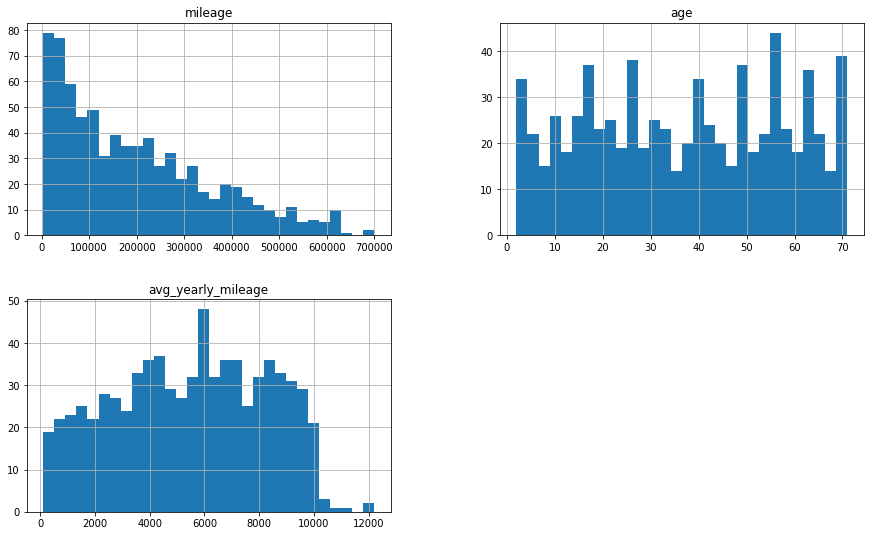

In [ ]:
num_columns = ["mileage", "age","avg_yearly_mileage"]
X_train[num_columns].hist(figsize=(15,9), bins=30)

można tu zaobserwować, że rozkład przebiegu jest silnie skośny, pozostałe 2 zmienne mają rozkład zbliżony do jednostajnego

In [ ]:
pt=PowerTransformer(standardize=False)

tworzymy obiekt klasy PowerTransformer, korzystamy tutaj z domyślnej transformacji Yeo-Johnson, zmieniamy natomiast ustawienie o sprowadzeniu do rozkładu o średniej równej 0 i odchyleniu standardowym równym 1, które domyślnie jest ustawione na True

<div class="alert alert-block alert-info">
<b>Info</b> 

Domyślna transformacja czyli metoda Yeo-Johnsona może być stosowana niezależnie od znaku transformowanych zmiennych, natomiast alternatywna transformacja Box-Cox wymaga ściśle dodatnich zmiennych na wejściu.
</div>

In [ ]:
pt.fit(X_train[num_columns])
X_train_num_transformed = pd.DataFrame(pt.transform(X_train[num_columns]), columns =num_columns)
X_test_num_transformed =  pd.DataFrame(pt.transform(X_test[num_columns]), columns =num_columns)

analogicznie jak przy poprzednio stosowanych transformerach korzystamy tutaj z metod fit i transform, a następnie konwertujemy wynik na ramkę danych.

Przeanalizujmy jak mocno zmieniły się rozkłady poszczególnych zmiennych:

array([[<AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'avg_yearly_mileage'}>,
        <AxesSubplot:>]], dtype=object)

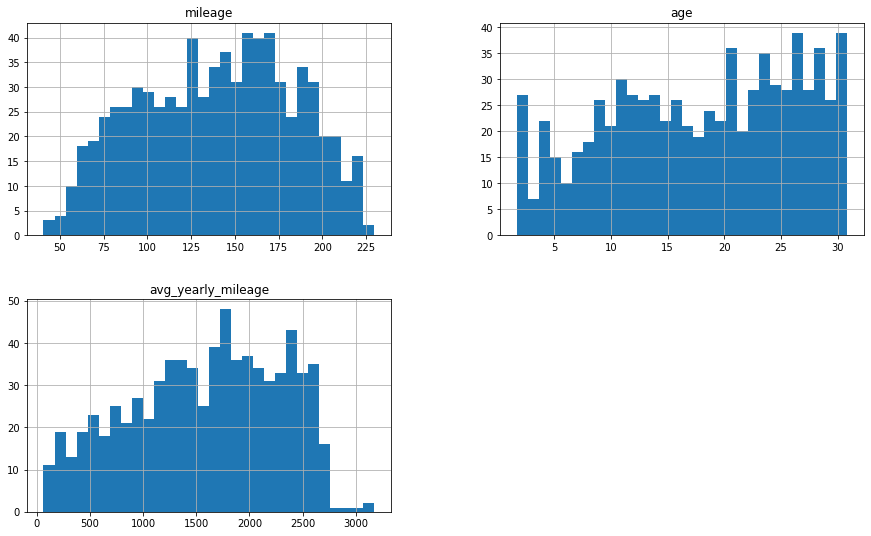

In [ ]:
X_train_num_transformed.hist(figsize=(15,9), bins=30)

array([[<AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'avg_yearly_mileage'}>,
        <AxesSubplot:>]], dtype=object)

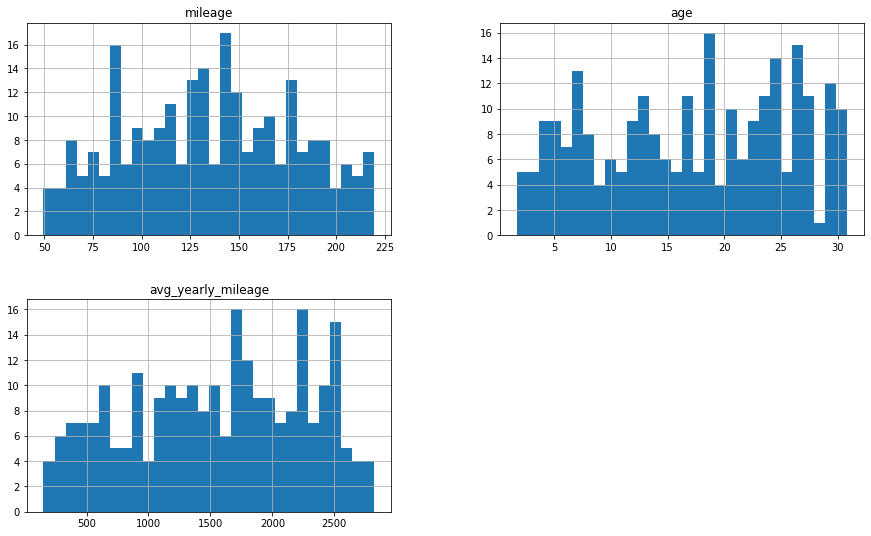

In [ ]:
X_test_num_transformed.hist(figsize=(15,9), bins=30)

Zmienna mileage na zbiorze treningowym z silnie skośnej nabrała cech rozkładu normalnego, pozostałe przypadki nie wyglądają jednak na rozkład normalny.

Wypróbujmy inny sposób modyfikacji rozkładu - <b>QuantileTransformer</b>

In [ ]:
from sklearn.preprocessing import QuantileTransformer

tworzymy obiekt klasy QuantileTransformer, zamiast bazowego rozkładu jednostajnego wybierając rozkład normalny

In [ ]:
qt = QuantileTransformer(output_distribution="normal")

In [ ]:
qt.fit(X_train[num_columns])
X_train_num_transformed = pd.DataFrame(qt.transform(X_train[num_columns]), columns =num_columns)
X_test_num_transformed =  pd.DataFrame(qt.transform(X_test[num_columns]), columns =num_columns)

array([[<AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'avg_yearly_mileage'}>,
        <AxesSubplot:>]], dtype=object)

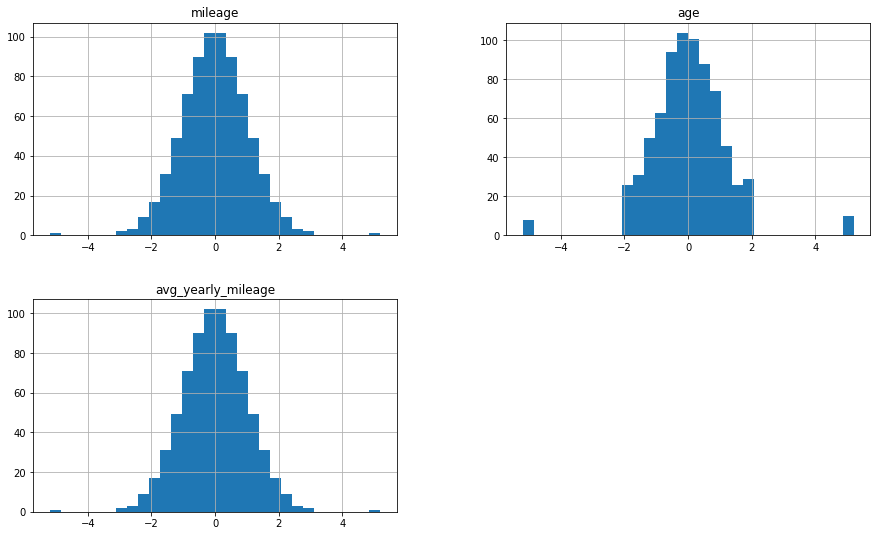

In [ ]:
X_train_num_transformed.hist(figsize=(15,9), bins=30)

array([[<AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'avg_yearly_mileage'}>,
        <AxesSubplot:>]], dtype=object)

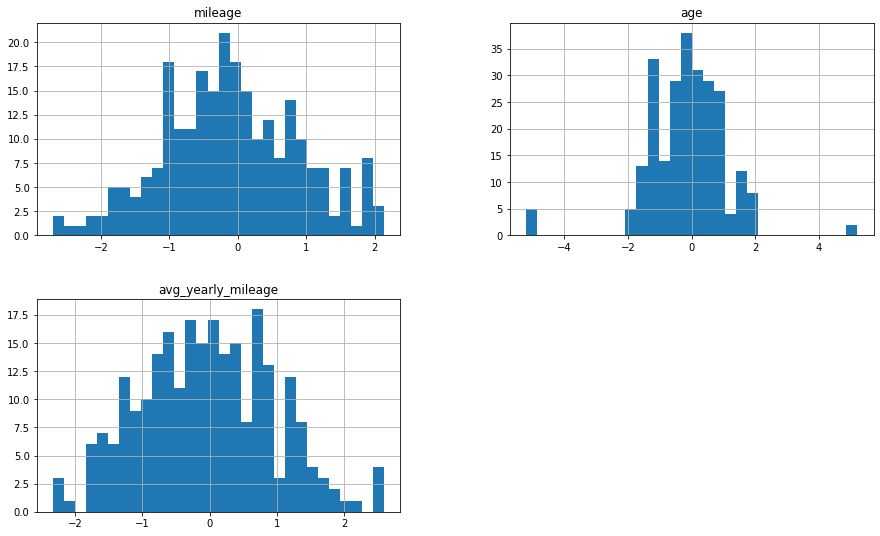

In [ ]:
X_test_num_transformed.hist(figsize=(15,9), bins=30)

Jak widzimy rozkłady są teraz zupełnie inne, na zbiorze treningowym bardzo zbliżone do rozkładu normalnego, jednak na zbiorze testowym juz dość znacznie się różnią, co może wynikać po części z niewielkiego rozmiaru próby.

<div class="alert alert-block alert-info">
<b>Info</b> 

To jaki dokładnie zestaw transformacji ostatecznie wybrać powinno wynikać przede wszystkim z obserwacji ustalonej wcześniej metryki jakości modelu.
</div>

# Łączenie zmiennych numerycznych w przedziały

podobnie jak w przypadku zmiennych kategorycznych, zmienne numeryczne również można przekształcać grupując razem pewne ich wartości. Proces taki nazywamy <b>kubełkowaniem</b>.

<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>Kubełkowanie</b> (ang. *binning*) polega na łączeniu wartości zmiennych numerycznych w przedziały, ma to na celu zmniejszenie możliwości przeuczenia modelu.
</div>

Wybór takich przedziałów może występować zarówno na podstawie cech rozkładu zmiennych (np wartości kwartyli) jak i wiedzy domenowej, tutaj zaprezentujemy obie możliwości.

do podziału wg statystyk pozycyjnych z rozkładu wykorzystamy funkcję <b>qcut</b> z biblioteki pandas

In [ ]:
X_train["mileage_binned_4"] = pd.qcut(X_train["mileage"], q=4)
X_train["mileage_binned_10"] = pd.qcut(X_train["mileage"], q=10)
X_train[["mileage","mileage_binned_4","mileage_binned_10"]]

,mileage,mileage_binned_4,mileage_binned_10
82,524486,"(293524.25, 699892.0]","(429566.5, 699892.0]"
991,166856,"(162418.5, 293524.25]","(162418.5, 212552.8]"
789,94191,"(61161.25, 162418.5]","(78348.9, 116729.4]"
894,54210,"(3784.999, 61161.25]","(48631.6, 78348.9]"
398,264049,"(162418.5, 293524.25]","(212552.8, 265707.6]"
...,...,...,...
106,127914,"(61161.25, 162418.5]","(116729.4, 162418.5]"
270,185880,"(162418.5, 293524.25]","(162418.5, 212552.8]"
860,116011,"(61161.25, 162418.5]","(78348.9, 116729.4]"
435,25782,"(3784.999, 61161.25]","(25757.7, 48631.6]"


Stworzyliśmy tutaj 2 nowe cechy na zbiorze treningowym w oparciu o kwartyle i decyle rozkładu zmiennej mileage. Jak widzimy poszczególnym wartościom przypisane zostały wartości przedziałów do których one wpadają w danym podziale na kubełki.

jeśli chcemy samodzielnie określić etykiety przedziałów można posłużyć się parametrem labels

In [ ]:
X_train["mileage_binned_4"] = pd.qcut(X_train["mileage"], q=4, labels=np.arange(1,5))
X_train["mileage_binned_10"] = pd.qcut(X_train["mileage"], q=10, labels=np.arange(1,11))
X_train[["mileage","mileage_binned_4","mileage_binned_10"]]

,mileage,mileage_binned_4,mileage_binned_10
82,524486,4,10
991,166856,3,6
789,94191,2,4
894,54210,1,3
398,264049,3,7
...,...,...,...
106,127914,2,5
270,185880,3,6
860,116011,2,4
435,25782,1,2


<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
    
Wszystkie przekształcenia wykorzystujące informacje o rozkładach cech należy implementować najpierw na zbiorze treningowym, a następnie w oparciu o rozkład ze zbioru treningowego - na zbiorze testowym. Inaczej wykorzystujemy informacje ze zbioru testowego i przestaje on być niezależny.
</div>

tutaj możemy skorzystać z parametru <b>retbins</b> i dostać granice kubełków a następnie w oparciu o te granice dokonać identycznego podziału na zbiorze testowym

In [ ]:
_, bins = pd.qcut(X_train["mileage"], q=4, retbins=True)
bins

array([  3785.  ,  61161.25, 162418.5 , 293524.25, 699892.  ])

alternatywnym podejściem jest użycie funkcji <b>cut</b> z biblioteki pandas, która pozwala podzielić wartości zmiennej na zdefiniowaną liczbę przedziałów o identycznej szerokości lub przypisać je do zdefiniowanych samodzielnie przedziałów

załóżmy, że jeśli chodzi o wiek samochodu znaczenie mają przedziały do 3 lat, od 3 do 7, od 7 do 12, 12-25 oraz ponad 25. Możemy łatwo dokonać takiego przypisania przydzielając poszczególnym kubełkom odpowiednie nazwy:

In [ ]:
X_train["age_binned"] = pd.cut(X_train["age"],[0,3,7,12,25,100], labels =["new","middle_age","old","very_old","extremely_old"] )
X_train[["age","age_binned"]]

,age,age_binned
82,65,extremely_old
991,25,very_old
789,21,very_old
894,67,extremely_old
398,36,extremely_old
...,...,...
106,31,extremely_old
270,59,extremely_old
860,14,very_old
435,7,middle_age


# Normalizacja i Standaryzacja

Załóżmy, że finalnie mamy zbiór danych złożony stricte ze zmiennych numerycznych:

In [ ]:
X_train = X_train.loc[:,["mileage","condition_transformed", "age","avg_yearly_mileage","is_classic"]]
X_test = X_test.loc[:,["mileage","condition_transformed", "age","avg_yearly_mileage","is_classic"]]
X_train

,mileage,condition_transformed,age,avg_yearly_mileage,is_classic
82,524486,2.0,65,8069.0,0.0
991,166856,3.0,25,6674.0,0.0
789,94191,2.0,21,4485.0,0.0
894,54210,1.0,67,809.0,0.0
398,264049,4.0,36,7335.0,0.0
...,...,...,...,...,...
106,127914,3.0,31,4126.0,0.0
270,185880,3.0,59,3151.0,0.0
860,116011,0.0,14,8286.0,0.0
435,25782,2.0,7,3683.0,0.0


możemy łatwo zaobserwować, że zmienne znacznie różnią się pod względem średniej czy wariancji:

In [ ]:
np.round(X_train.describe(),2)

,mileage,condition_transformed,age,avg_yearly_mileage,is_classic
count,750.00,750.00,750.00,750.00,750.00
mean,198670.12,2.41,36.94,5458.12,0.01
std,158883.17,1.16,20.34,2766.60,0.12
min,3785.00,0.00,2.00,118.00,0.00
25%,61161.25,2.00,19.00,3306.75,0.00
50%,162418.50,2.00,37.00,5615.00,0.00
75%,293524.25,3.00,55.00,7816.25,0.00
max,699892.00,4.00,71.00,12205.00,1.00


Niektóre metody modelowania są zależne od odległości bądź wariancji zmiennych, więc chcąc aby wpływ danej zmiennej na predykcje wynikał przede wszystkim z jej związku ze zmienną celu, a nie ze skali, powinniśmy zastosować <b>normalizację</b> lub <b>standaryzację</b>

zacznijmy od normalizacji, zrealizujemy ją za pomocą kolejnego transformera z biblioteki sklearn: MinMaxScaler

<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>Normalizacja</b> polega na przekształcaniu zmiennej do zakresu wartości <0,1> poprzez odjęcie minumum i podzielenie przez różnicę pomiędzy maksimum a minimum z rozkładu.
</div>

In [ ]:
from sklearn.preprocessing import MinMaxScaler

tworzymy obiekt klasy MinMaxScaler korzystając z bazowych ustawień, możliwa jest zmiana docelowego zakresu wartości z bazowego <0,1> na dowolnie wybrany poprzez użycie parametru <b>feature_range</b>

In [ ]:
mm = MinMaxScaler()

Metody są oczywiście analogiczne jak w poprzednich przypadkach, konwertujemy wyniki z powrotem na ramki danych aby łatwiej było je oglądać

In [ ]:
mm.fit(X_train)
X_train_mm_scaled = pd.DataFrame(mm.transform(X_train), columns=X_train.columns)
X_test_mm_scaled = pd.DataFrame(mm.transform(X_test), columns=X_test.columns)
np.round(X_train_mm_scaled.describe(),2)

,mileage,condition_transformed,age,avg_yearly_mileage,is_classic
count,750.00,750.00,750.00,750.00,750.00
mean,0.28,0.60,0.51,0.44,0.01
std,0.23,0.29,0.29,0.23,0.12
min,0.00,0.00,0.00,0.00,0.00
25%,0.08,0.50,0.25,0.26,0.00
50%,0.23,0.50,0.51,0.45,0.00
75%,0.42,0.75,0.77,0.64,0.00
max,1.00,1.00,1.00,1.00,1.00


jak widzimy wszystkie cechy zostały teraz przeniesione do tego samego zakresu wartości <0,1>, ale ich średnia i odchylenie standardowe nie są identyczne. Oczywiście nie mamy gwarancji, że na nowych danych nie pojawią się wartości spoza wykresu widzianego na zbiorze treningowym. Jeśli chcemy być pewni, że znormalizowane zmienne zachowają swój zakres wartości należy tworząc obiekt klasy MinMaxScaler ustawić parametr <b>clip</b> na True.

<div class="alert alert-block alert-danger">
<b>Uwaga!</b> 
    
Nie zaleca się korzystania z MinMaxScaler dla zmiennych posiadających <b>wartości odstające</b>. Jeśli takie wartości nie zostaną wcześniej prawidłowo obsłużone, to większość "normalnych" wartości zmiennej będzie "upchana" w małym zakresie wartości co nie będzie sprzyjać jej wartości dla predykcji. 
</div>

zaprezentujemy teraz przykład standaryzacji z wykorzystaniem transformera StandardScaler z biblioteki sklearn

<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>Standaryzacja</b> polega na przekształcaniu zmiennej do rozkładu o wartości oczekiwanej 0 i odchyleniu standardowym 1 poprzez odjęcie średniej i podzielenie przez odchylenie standardowe
</div>

In [ ]:
from sklearn.preprocessing import StandardScaler

tworzymy obiekt klasy StandardScaler korzystając z bazowych ustawień

In [ ]:
ss =StandardScaler()

Metody rownież są analogiczne jak w poprzednich przypadkach, konwertujemy wyniki z powrotem na ramki danych aby łatwiej było je oglądać

In [ ]:
ss.fit(X_train)
X_train_ss_scaled = pd.DataFrame(ss.transform(X_train), columns=X_train.columns)
X_test_ss_scaled = pd.DataFrame(ss.transform(X_test), columns=X_test.columns)
np.round(X_train_ss_scaled.describe(),2)

,mileage,condition_transformed,age,avg_yearly_mileage,is_classic
count,750.00,750.00,750.00,750.00,750.00
mean,0.00,-0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00
min,-1.23,-2.08,-1.72,-1.93,-0.12
25%,-0.87,-0.35,-0.88,-0.78,-0.12
50%,-0.23,-0.35,0.00,0.06,-0.12
75%,0.60,0.51,0.89,0.85,-0.12
max,3.16,1.37,1.68,2.44,8.20


W przeciwieństwie do poprzedniego przekształcenia zmienne mają identyczną średnią i odchylenie standardowe, za to różnią sie zakresami wartości.

<div class="alert alert-block alert-info">
<b>Info</b> 

Jako że StandardScaler opiera się na użyciu średniej i odchylenia standardowego z transformowanej zmiennej, również nie jest on wolny od wpływu wartości odstających. Jeśli chcemy być pewni, że wartości odstające nie będą miały wpływu na skalę przekształconej zmiennej można skorzystać z klasy <b>RobustScaler</b> 
</div>

# łączenie różnych transformacji w ramach pipeline

cofnijmy się teraz na chwilę do etapu generowania danych i zobaczmy jak można w łatwy i niezawodny sposób łączyć ze sobą różne transformacje z wykorzystaniem obiektów Pipeline oraz ColumnTransformer

<div class="alert alert-block alert-success">
<b>Definicja</b> 

<b>Pipeline</b> jest to przepływ danych przez ułożone w kolejności moduły wykonujące ustalone transformacje, zazwyczaj ostatnim elementem jest model predykcyjny
</div>

In [ ]:
UsedCars_df =generate_used_cars_data()
X = UsedCars_df.drop("selling_price",axis=1)
y = UsedCars_df["selling_price"]
X["age"] = 2021 - X["year_manufactured"]
X.drop("year_manufactured", axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)
X_train

,condition,mileage,brand,age
82,very_good,69205,Skoda,6
991,good,322639,VW,46
789,good,86970,Fiat,20
894,very_good,524559,Fiat,66
398,medium,18954,Audi,35
...,...,...,...,...
106,good,209892,Renault,38
270,very_good,108168,Seat,51
860,good,39632,Mercedes,59
435,medium,267041,Fiat,50


zdefiniujmy teraz grupy zmiennych, które będziemy poddawać poszczególnym transformacjom:

In [ ]:
columns_for_ordinal_encoding =["condition"]
columns_for_target_encoding =["brand"]
numerical_columns =["age","mileage"]

następnie importujemy niezbędne klasy

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

definiujemy pipeline do przetwarzania poszczególnych grup kolumn, pipeline mogą zawierać wiele kroków, tutaj dla uproszczenia wykorzystamy jednoelementowe

In [ ]:
pipeline_oe = Pipeline(steps =[("OrdinalEncoder",
                            OrdinalEncoder(
                               categories =[['very_bad', 'bad', 'medium', 'good', 'very_good']],
                               handle_unknown ='use_encoded_value', unknown_value=np.NaN))])

pipeline_jse = Pipeline(steps=[("JamesSteinEncoder",JamesSteinEncoder())])

pipeline_num = Pipeline(steps=[("PowerTransformer",PowerTransformer(standardize=False))])

następnie przypisujemy zmienne do poszczególnych transformacji, korzystając z obiektu ColumnTransformer

In [ ]:
column_transformer = ColumnTransformer(
                        transformers=[
                         ('categorical_oe', pipeline_oe, columns_for_ordinal_encoding),
                         ('categorical_jse', pipeline_jse, columns_for_target_encoding),
                         ('numerical', pipeline_num, numerical_columns)
                         ])

sam ColumnTransformer również może być częścią pipeline, przykładowo możemy na koniec zastosować standaryzacje

In [ ]:
preprocessing_pipeline = Pipeline(steps = [
                        ("column_transformer", column_transformer),
                        ("scaler",StandardScaler())
                    ])

jeśli używamy pipeline bez modelu predykcyjnego na końcu to stosujemy te same metody co przy zwykłych transformerach

In [ ]:
preprocessing_pipeline.fit(X_train,y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_oe',
                                                  Pipeline(steps=[('OrdinalEncoder',
                                                                   OrdinalEncoder(categories=[['very_bad',
                                                                                               'bad',
                                                                                               'medium',
                                                                                               'good',
                                                                                               'very_good']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['condit

po uruchomieniu metody fit widzimy wszystkie kroki całego pipeline

In [ ]:
X_train_transformed = preprocessing_pipeline.transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)
print(f"rozmiar zbioru treningowego po transformacji: {X_train_transformed.shape}")
print(f"rozmiar zbioru testowego po transformacji: {X_test_transformed.shape}")
print(X_train_transformed)

rozmiar zbioru treningowego po transformacji: (750, 4)
rozmiar zbioru testowego po transformacji: (250, 4)
[[ 1.34093122 -0.77016684 -1.5987142  -0.59924888]
 [ 0.46641086 -0.80925124  0.58475157  0.97365003]
 [ 0.46641086 -0.7939586  -0.68985786 -0.40448688]
 ...
 [ 0.46641086  0.70876962  1.13401097 -1.02756173]
 [-0.4081095  -0.7939586   0.75822769  0.74397369]
 [ 0.46641086  0.80959101 -0.36550292 -1.35095193]]


jak widzimy zwrócony zbiór treningowy ma typ danych array a jego wymiary odpowiadają tym przed transformacją, zgodność wymiarów zależy jednak od zastosowanych transformacji

jeśli pipeline jest zakończony modelem predykcyjnym jego metody są identyczne jak metody modelu, czyli korzystamy z fit i predict, tak jak w poniższym przykładzie

In [ ]:
from sklearn.linear_model import LinearRegression

final_pipeline = Pipeline(steps = [
                ("preprocessing", preprocessing_pipeline),
                ("model", LinearRegression())
                ])

poniżej pokazujemy jak wytrenować pipeline w oparciu o zbiór treningowy a następnie dokonać predykcji na zbiorze testowym

In [ ]:
final_pipeline.fit(X_train, y_train)
X_test_predicted = pd.Series(final_pipeline.predict(X_test),name="prediction")
X_test_predicted.head()

0     9649.925584
1    30782.788094
2    44681.214268
3     5967.815692
4    45684.785298
Name: prediction, dtype: float64

# Podsumowanie

Powyżej zaprezentowaliśmy kilka różnych przykładów przekształcania surowych danych w cechy predykcyjne przydatne przy modelowaniu. Niektóre transformacje można z powodzeniem stosować przy pracy nad innymi problemami, inne należy raczej potraktować jako inspirację. Ważne aby prace nad Feature Engineering poprzedzone były dobrym zrozumieniem danych. Niezwykle ważne jest tutaj aby już na tym etapie stosować odpowiednią strategię walidacyjną, aby zapobiec korzystaniu z informacji ze zbioru testowego, inaczej nasze wyniki nie będą miarodajne.